### **Importing Packages**

In [21]:
!pip install pyspellchecker

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import re
import string
from spellchecker import SpellChecker
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natasha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# loading the data
df = pd.read_csv('tweets.csv')
display(df.head())
display(df.info())

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


None

- Only the Text column will be used to classify whether a tweet refers to a disaster or not. So the id, keyword and location columns can be dropped

In [24]:
# dropping unnecessary columns
df = df.drop(['id', 'keyword', 'location'], axis=1)

### **EDA**

Text(0.5, 1.0, 'Target distribution: 0 & 1')

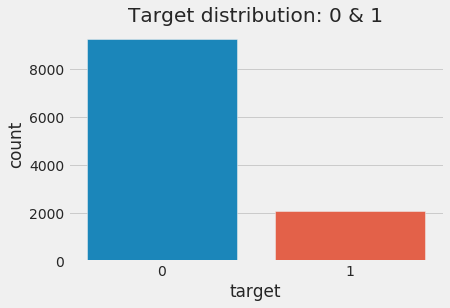

In [25]:
# checking the balance of the data according to the target column
sns.countplot(df.target)
plt.title('Target distribution: 0 & 1')

- To get better visualization of the percentage distribution of our data lets plot a funnel-chart.

In [26]:
temp = df.groupby('target').count()['text'].reset_index().sort_values(by='text', ascending='False')
fig = go.Figure(go.Funnelarea(
    text = temp.target,
    values = temp.text, 
    title = {'position':'top center', 'text':'Funnel-Chart showin Target Distribution'}
))
fig.show()

- The data is very imbalanced which means we will have to use a balancing technique since most machine learning classification alorithms are not equipped to handle imbalanced classes.
- But first lets take a look at our data.



In [27]:
display(df[df['target'] == 0]['text'].values[0])
display(df[df['target'] == 1]['text'].values[0])

'"Lord Jesus, your love brings freedom and pardon. Fill me with your Holy Spirit and set my heart ablaze with your l… https://t.co/VlTznnPNi8'

'Communal violence in Bhainsa, Telangana. "Stones were pelted on Muslims\' houses and some houses and vehicles were set ablaze…'

- The data contains punctuations and links that should be removed before extracting any other information from the data.
- Let's now compare the number of characters and words in tweets about a disaster and those that are not.

#### Number of characters

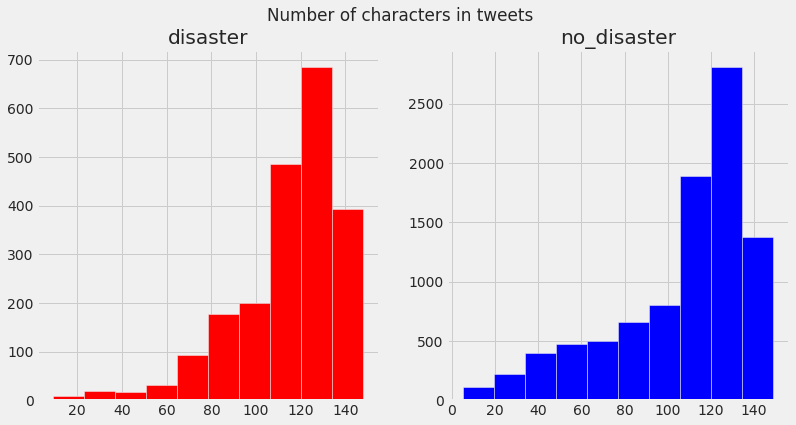

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2)
disaster = df[df['target'] == 1]['text'].str.len()
ax1.hist(disaster, color='red')
ax1.set_title('disaster')
no_disaster = df[df['target'] == 0]['text'].str.len()
ax2.hist(no_disaster, color='blue')
ax2.set_title('no_disaster')
plt.suptitle('Number of characters in tweets')
plt.gcf().set_size_inches(12,6)

- The distribution of characters in the tweets seems to be similar for those about disasters and those that are not.


#### Number of words

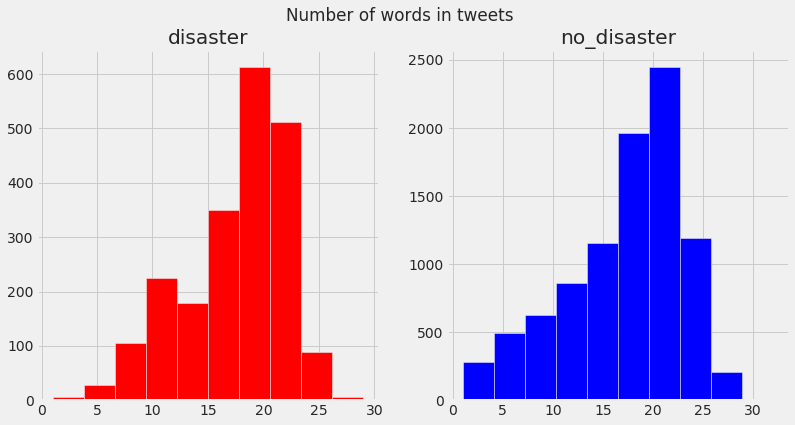

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2)
disaster = df[df['target'] == 1]['text'].str.split().apply(lambda x:len(x))
ax1.hist(disaster, color='red')
ax1.set_title('disaster')
no_disaster = df[df['target'] == 0]['text'].str.split().apply(lambda x:len(x))
ax2.hist(no_disaster, color='blue')
ax2.set_title('no_disaster')
plt.suptitle('Number of words in tweets')
plt.gcf().set_size_inches(12,6)

#### Average Word-length per tweet

Average no. of words for disaster tweets is: 5.8800640131748265
Average no. of words for no_disaster tweets is: 5.514464721369072


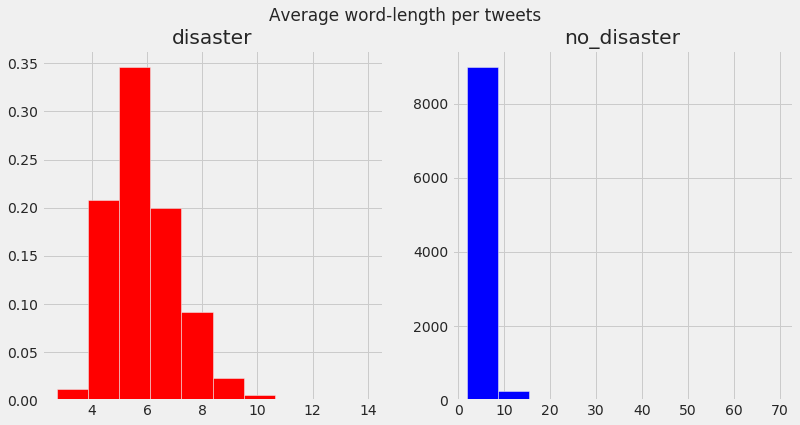

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2)
disaster = df[df['target'] == 1]['text'].str.split().apply(lambda x : [len(i) for i in x])
disaster = disaster.apply(lambda x: np.mean(x))
ax1.hist(disaster, color='red', density=True)
ax1.set_title('disaster')
no_disaster = df[df['target'] == 0]['text'].str.split().apply(lambda x: [len(i) for i in x])
no_disaster = no_disaster.apply(lambda x: np.mean(x))
ax2.hist(no_disaster, color='blue')
ax2.set_title('no_disaster')
plt.suptitle('Average word-length per tweets')
plt.gcf().set_size_inches(12,6)
print('Average no. of words for disaster tweets is:', disaster.mean())
print('Average no. of words for no_disaster tweets is:', no_disaster.mean())

### **Preprocessing**

- Now lets clean the text to remove the tags, links, punctuation etc to make our data ready for processing.

In [31]:
def text_preprocessing(text):
  # removing hyperlinks
  url = re.compile(r'https?://\S+|www\.\S+')
  text = url.sub('', text)

  # removing html tags
  html = re.compile(r'<.*?')
  text = html.sub(r'', text)

  # removing punctuation
  trans = str.maketrans('', '', string.punctuation)
  text = text.translate(trans)

  # converting to lowercase
  text = text.lower()

  # removing emojis
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)  
  text = emoji_pattern.sub(r'', text)
  # removing stopwords
  text = [char for char in text.split() if char.lower() not in stopwords.words('english')]
  text = " ".join(text)
  return text

df['text'] = df['text'].apply(text_preprocessing)
df

,text,target
0,communal violence bhainsa telangana stones pel...,1
1,telangana section 144 imposed bhainsa january ...,1
2,arsonist sets cars ablaze dealership,1
3,arsonist sets cars ablaze dealership,1
4,lord jesus love brings freedom pardon fill hol...,0
...,...,...
11365,media warned us well advance wrecked whole nig...,0
11366,feel directly attacked consider moonbin amp ji...,0
11367,feel directly attacked consider moonbin amp ji...,0
11368,ok remember outcast nd dora au au wrecked nerv...,0


(-0.5, 1599.5, 799.5, -0.5)

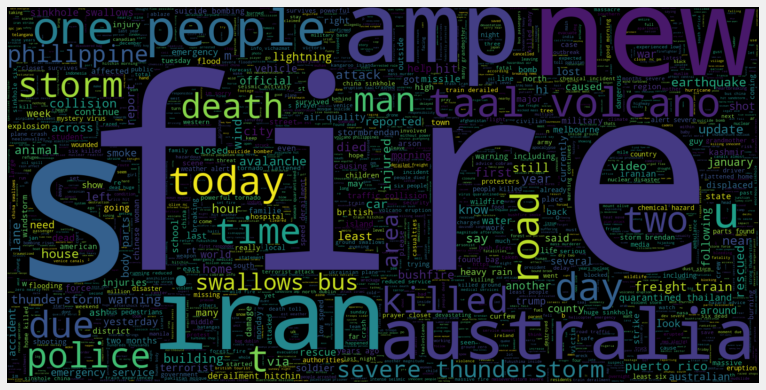

In [32]:
# wordcloud for labels in disaster tweets
plt.figure(figsize=(12,12))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df['target'] == 1]['text']))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')

(-0.5, 1599.5, 799.5, -0.5)

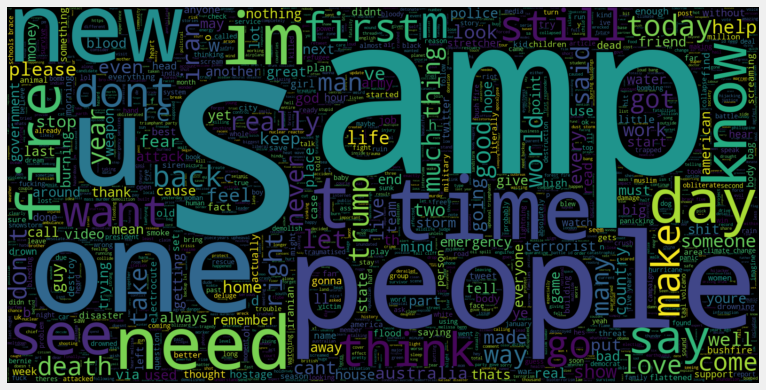

In [33]:
# wordcloud for no-disaster tweets
plt.figure(figsize = (12,12))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(' '.join(df[df['target'] == 0]['text']))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')

In [34]:
# # correcting misspelled words
# from spellchecker import SpellChecker
# correct = SpellChecker()
# def correct_words(text):
#   corrected = []
#   misspelled = correct.unknown(text.split())
#   for word in text.split():
#     if word in misspelled:
#       corrected.append(correct.correction(word))
#     else:
#        corrected.append(word)
#   return ' '.join(corrected)

# df['text'] = df['text'].apply(lambda x: correct_words(x))

In [35]:
df['text']

0        communal violence bhainsa telangana stones pel...
1        telangana section 144 imposed bhainsa january ...
2                     arsonist sets cars ablaze dealership
3                     arsonist sets cars ablaze dealership
4        lord jesus love brings freedom pardon fill hol...
                               ...                        
11365    media warned us well advance wrecked whole nig...
11366    feel directly attacked consider moonbin amp ji...
11367    feel directly attacked consider moonbin amp ji...
11368    ok remember outcast nd dora au au wrecked nerv...
11369                 jake corway wrecked running 14th irp
Name: text, Length: 11370, dtype: object

### **Building the Model** 

In [36]:
# splitting the data
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101, stratify = y)

# vectorizing the text data
tfidf = TfidfVectorizer(min_df=3, max_df=0.5, analyzer='char_wb', ngram_range=(3,5), max_features = 1000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2777
           1       0.74      0.31      0.44       634

    accuracy                           0.85      3411
   macro avg       0.80      0.64      0.68      3411
weighted avg       0.84      0.85      0.83      3411



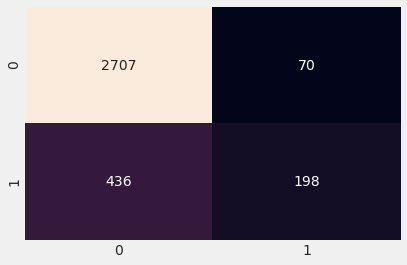

In [37]:
# creating the model
logreg = LogisticRegression()
logreg.fit(X_train_vec, y_train)
y_pred = logreg.predict(X_test_vec)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'g', cbar = False)

- The model has an accuracy of 87% percent depite the fact that more than half of the class 1 data points are wrongly classified which can be seen from the confusion matrix.
- The f1 score is a more valid metric as it gives an average of both precision and recall, giving a measure of the model's ability to separate the samples into classes.
- This is because the data is imbalanced.
- The next step is balancing the data to see if the model performs better.

### Balancing the data

- Balancing data is important in order to allow your model to effectively learn the decision boundary.
- We will balance the data using simple oversampling and undersampling then compare the performance.

#### Simple Undersampling

- Undersampling involves keeping all data point from the minority class and reducing the number of samples in the majority class.

In [38]:
# sectioning the data
X_train_vec = pd.DataFrame(X_train_vec.toarray())
# X_test_vec = pd.DataFrame(X_test_vec.toarray())
# df_train = pd.concat([X_train_vec, y_train], axis = 1)
# df_test = pd.concat([X_test_vec, y_test], axis = 1)

# disaster_us = df_train[df_train['target'] == 1]
# nondisaster_us = df_train[df_train['target'] == 0]



In [39]:
X_train_vec 

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7954,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7955,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7956,0.00000,0.0,0.0,0.0,0.0,0.221325,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7957,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
